In [1]:
import pandas as pd
from db.graph import Neo4JConnector
from neo4j.graph import Node, Relationship
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

In [2]:
node_color_map = {"Champion": "r", "Position": "g", "Player": "b"}

In [3]:
neo4j = Neo4JConnector.create_from_config("../config.ini")

In [5]:
g = nx.DiGraph()
query = """CALL {
        MATCH (p:Player)-[pi:PLAYS_IN]->(pim:PlayerInMatch)
        WITH p, COUNT(pim.matchID) AS matchesPlayed 
        WHERE matchesPlayed > 10
        RETURN p
        LIMIT 100
    }
    MATCH (p)-[pc:PLAYS_CHAMP]->(c:Champion), (p)-[hp:HAS_POSITION]->(pos:Position)
    RETURN *"""

neo4j.create_graph_from_query(graph=g, query=query)
str(g)

'DiGraph with 129 nodes and 246 edges'

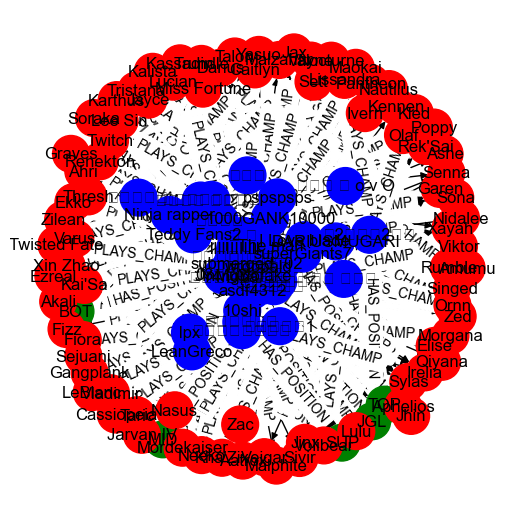

In [7]:
plt.figure(figsize=(5, 5))

node_labels = {}
node_colors = [] 
for node in g.nodes:
    node_colors.append(node_color_map[g.nodes[node]["type"]]) 
    
    if g.nodes[node]["type"] == "Position":
        node_labels[node] = g.nodes[node]["properties"]["positionID"]
    elif g.nodes[node]["type"] == "Player":
        node_labels[node] = g.nodes[node]["properties"]["summonerName"]
    elif g.nodes[node]["type"] == "Champion":
        node_labels[node] = g.nodes[node]["properties"]["championName"]
        
pos = nx.spring_layout(g)  # Positions for all nodes
nx.draw(g, pos, with_labels=False, node_size=700, node_color=node_colors, font_size=10, font_weight="bold")
nx.draw_networkx_labels(g, pos, labels=node_labels)

edge_labels = nx.get_edge_attributes(g, "type")
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)

# Show plot
plt.show()

In [8]:
node2vec = Node2Vec(g, dimensions=2, walk_length=30, num_walks=200, workers=4)  

Computing transition probabilities:   0%|          | 0/129 [00:00<?, ?it/s]

In [9]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

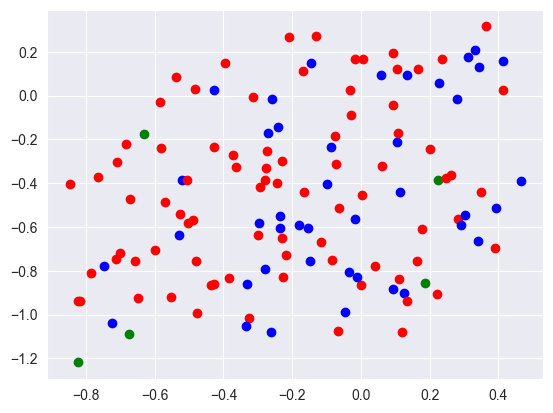

In [10]:
# PLAYS_CHAMP]->(c:), (p)-[hp:HAS_POSITION]->(pos:
for i, node in enumerate(g.nodes):
    plt.scatter(model.wv.vectors[i, 0], model.wv.vectors[i, 1], color=node_color_map[g.nodes[node]["type"]])

plt.show()